In [ ]:
import pandas as pd
import os

In [ ]:
# need this code snippet in each notebook to mount the google drive
from google.colab import drive  
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
os.chdir("/content/gdrive/My Drive/Colab Notebooks/CPTx Alerts/")
!ls

alerts2.csv  alerts3.csv  Alerts_Classification_Top2Vec.py  top2vec_saved


In [ ]:
for df_alerts in pd.read_csv("alerts3.csv", iterator=True, chunksize=100000):
    break 
df_alerts.shape

(100000, 7)

In [ ]:
df_alerts.head()

,tenant_id,sensor_type,message,priority,blocked,classification,direction
0,10005,ISENSOR,5616 VID14123 SecureWorks SOC Test Alert,4,3.0,0,NaN
1,10005,ISENSOR,5616 VID14123 SecureWorks SOC Test Alert,4,3.0,0,NaN
2,10005,ISENSOR,50243 VID59478 SSLv3 Large Heartbeat Content D...,5,1.0,0,NaN
3,10005,ISENSOR,50243 VID59478 SSLv3 Large Heartbeat Content D...,5,1.0,0,NaN
4,10005,ISENSOR,50192 VID59478 SSLv3 Large Heartbeat Content D...,2,1.0,0,NaN


In [ ]:
df_alerts.message.head(
)

0             5616 VID14123 SecureWorks SOC Test Alert
1             5616 VID14123 SecureWorks SOC Test Alert
2    50243 VID59478 SSLv3 Large Heartbeat Content D...
3    50243 VID59478 SSLv3 Large Heartbeat Content D...
4    50192 VID59478 SSLv3 Large Heartbeat Content D...
Name: message, dtype: object

**Core data points used for classification of alert into a unified kill chain model stage:**

  sensor_type = ISENSOR
  
  message = 48920 VID54145 SIPVicious SIP VoIP Auditing Tool User-Agent (friendly-scanner) 

(Inbound)


**Here is what Tomasz Racsek had for potential classifications/buckets:**

**-Initial Foothold**

    External Information Gathering
    External Weakness Identification
    Initial Access
    Privilege Escalation
    Defense Evasion
    Persistence
    Command and Control

**-Propagation**

    Internal Information Gathering
    Internal Weakness Identification
    Discovery
    Lateral Movement
    Credential Access
 
**Actions on Objectives**

    Collection
    Exfiltration
    Impact

In [ ]:
df_alerts.columns

Index(['tenant_id', 'sensor_type', 'message', 'priority', 'blocked',
       'classification', 'direction'],
      dtype='object')

In [ ]:
# find unique classification ids
set(df_alerts.classification)

{0, 82}

In [ ]:
# filter by sensor type
df_alerts = df_alerts.loc[df_alerts['sensor_type'] == 'ISENSOR' ] 

filter on: ['malicious,'medium-risk','bad-unknown','FILELOG MALWARE EVENT','IPS:DNS Enforcement Violation','IPS:SSL Enforcement Violation','IPS:Scanner Enforcement Violation','IPS:Web Server Enforcement Violation','IPS:Web Server Enforcement Violation','anomaly_http:Block HTTP Non Compliant',]

**Cleaning Unstructured Text Data**

The most important thing we need to do to help our topic modelling algorithm is to pre-clean up the alerts. As you look back at the alerts you may notice that they are very untidy, with non-standard English, capitalisation, links, hashtags, @users and punctuation and emoticons everywhere. If we are going to be able to apply topic modelling we need to remove most of this and massage our data into a more standard form before finally turning it into vectors.

First we will start with imports for this specific cleaning task.

In [ ]:
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

In the master function we apply these steps in order:

After this we make the whole alert lowercase as otherwise the algorithm would think that the words ‘malicious’ and ‘Malicious’ were the same. 

Next we remove punctuation characters, contained in the my_punctuation string, to further tidy up the text. We need to do this or we could find tokens* which have punctuation at the end or in the middle.

In the next two steps we remove double spacing that may have been caused by the punctuation removal and remove numbers.
By now the data is a lot tidier and we have only lowercase letters which are space separated. 

Next we change the form of our alerts from a string to a list of words. We also remove stopwords in this step. Stopwords are simple words that don’t tell us very much. 

In the next step we stem the words in the list. This is essentially where we knock the end off the words. We do this so that similar words will be recognised as the same word by the algorithm. For example in the starfish example we would like it so that the algorithm knows that when it sees ‘regenerate’, ‘regenerated’, ‘regenerates’, ‘regeneration’ or ‘regenerating’ that it will know these are really the same word whilst it is building up topics. It can’t do this itself, so we knock off the word endings so that each of these words will become the same stem - ‘regener’. Once you have copied the word_rooter function, use this line of code to see that these words all become the same thing [word_rooter(w) for w in ['regenerate', 'regenerated', 'regenerates', 'regeneration', 'regenerating', 'regenerative']]. Note that the word_rooter function, which is a Porter Stemming function, only uses rules of thumb to know where to cut off words, and so for the word ‘regenerative’ it will actually give it a different root to the other words.
If we decide to use it the next step will construct bigrams from our tweet. This part of the function will group every pair of words and put them at the end, thus creating bigrams. The reason for doing this is that when we go from sentence to vector form of the alerts, we will lose the information about word ordering.  Later we will filter by appearance frequency and so unnatural bigrams  will be thrown out as they won’t appear enough to make it into the most popular tokens*.

In the cell below I provide  some functions to remove non text characters.  We will also remove repetitions and mentions in the corpus. We remove these because it is unlikely that they will help us form meaningful topics.

In [ ]:
# Python program to Remove all  digits from a list of string 
import re 
docs = df_alerts['message'].tolist()  

def remove(list):
    try: 
       pattern = '[0-9]'
       list = [re.sub(pattern, '', i) for i in list] 
       pattern = 'VID'
       list = [re.sub(pattern, '', i) for i in list]
    except:
       return list 
    return list

# now purge digits from alerts
docs = remove(docs)
df_alerts.message = docs

In [ ]:
df_alerts.head()

,tenant_id,sensor_type,message,priority,blocked,classification,direction
0,10005,ISENSOR,SecureWorks SOC Test Alert,4,3.0,0,NaN
1,10005,ISENSOR,SecureWorks SOC Test Alert,4,3.0,0,NaN
2,10005,ISENSOR,SSLv Large Heartbeat Content Detected (from ...,5,1.0,0,NaN
3,10005,ISENSOR,SSLv Large Heartbeat Content Detected (from ...,5,1.0,0,NaN
4,10005,ISENSOR,SSLv Large Heartbeat Content Detected (from_...,2,1.0,0,NaN


# **Topic Modeling and Search with Top2Vec:**

Top2Vec is an algorithm for topic modelling and semantic search. It automatically detects topics present in text and generates jointly embedded topic, document and word vectors. Once you train the Top2Vec model you can:

Get number of detected topics.
Get topics.
Search topics by keywords.
Search documents by topic.
Find similar words.
Find similar documents.

The assumption the algorithm makes is that many semantically similar documents are indicative of an underlying topic. The first step is to create a joint embedding of document and word vectors. Once documents and words are embedded in a vector space the goal of the algorithm is to find dense clusters of documents, then identify which words attracted those documents together. Each dense area is a topic and the words that attracted the documents to the dense area are the topic words.

In [ ]:
!pip install top2vec==1.0.6

In [ ]:
import json
import os
from top2vec import Top2Vec

In [ ]:
!pip install joblib==0.17.0

# **Train Top2Vec Model**
details here: 
https://github.com/ddangelov/Top2Vec

In [ ]:
top2vec = Top2Vec(documents=df_alerts.message, speed="deep-learn", workers=4)
top2vec.save("top2vec_saved")

**Parameters:**

documents: Input corpus, should be a list of strings.

*speed:* This parameter will determine how fast the model takes to train. The '**fast-learn**' option is the fastest and will generate the lowest quality vectors. The '**learn**' option will learn better quality vectors but take a longer time to train. The '**deep-learn**' option will learn the best quality vectors but will take significant time to train.



In [ ]:
top2vec.get_num_topics()

81

In [ ]:
topic_words, word_scores, topic_nums = top2vec.get_topics(top2vec.get_num_topics())

In [ ]:
pd.DataFrame(topic_words).T.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80
0,all,int,dorkbot,encoded,win,win,all,eval,int,url,share,xss,win,win,win,win,zgrab,int,snmp,openssl,select,xss,script,eval,eval,nuclei,script,script,remote,traversal,xss,sipvicious,protection,protection,script,code,disclosure,openssl,dorkbot,dorkbot,...,eval,cve,request,stdin,remote,request,get,with,stdin,test,test,test,test,public,snmp,test,test,test,signature,remote,signature,logon,function,cve,script,destination,destination,responses,heartbeat,responses,responses,responses,responses,script,lookup,lookup,botnet,botnet,environ,environ
1,union,default,win,byte,boot,boot,int,code,uri,byte,unicode,script,boot,boot,boot,boot,win,win,public,botnet,xss,script,xss,php,code,openvas,xss,xss,thinkphp,directory,source,protection,xss,xss,function,eval,uninterpreted,heartbeat,zgrab,zgrab,...,cve,remote,command,eval,command,openssl,openssl,get,eval,alert,alert,alert,alert,snmp,public,alert,alert,alert,remote,soc,remote,failure,rce,openvas,function,cve,cve,destination,exploitation,scanning,scanning,destination,destination,rce,extreme,check,scanning,scanning,self,self
2,int,win,zgrab,inclusion,zgrab,zgrab,signature,php,signature,upload,ipc,uri,ini,zgrab,zgrab,zgrab,int,uri,default,remote,script,select,environ,code,php,zmeu,disclosure,disclosure,code,execution,script,tool,script,script,xss,execution,source,large,nuclei,nuclei,...,self,thinkphp,get,code,code,get,execution,openssl,thinkphp,soc,soc,secureworks,secureworks,community,community,soc,secureworks,secureworks,repeated,signature,destination,repeated,variable,zmeu,protection,openvas,vulnerability,ip,variable,ip,repeat,ip,ip,cve,check,extreme,exploitation,exploitation,proc,lfi
3,select,snmp,boot,null,ini,ini,select,stdin,win,null,windows,environ,zgrab,ini,ini,ini,boot,select,community,code,sql,sql,disclosure,stdin,stdin,test,rce,rce,cve,incoming,uninterpreted,friendly,sipvicious,sipvicious,header,uninterpreted,script,exploitation,openvas,openvas,...,php,code,execution,thinkphp,thinkphp,command,from,heartbeat,execution,nuclei,openvas,soc,soc,default,default,secureworks,soc,soc,failure,sql,select,remote,environment,agent,environment,vulnerability,openvas,repeat,scanning,repeat,ip,scanning,scanning,thinkphp,ip,ip,code,openssl,lfi,proc
4,uri,boot,environ,file,lookup,lookup,union,phpunit,union,exploitation,test,union,environ,environ,select,select,dorkbot,boot,with,wget,stdin,stdin,uninterpreted,phpunit,phpunit,cve,source,possible,nonecms,openssl,rce,auditing,tool,tool,environment,cve,xss,sslv,zmeu,zmeu,...,proc,from,cve,remote,get,server,command,outbound,code,zmeu,nuclei,nuclei,nuclei,with,with,nuclei,nuclei,nuclei,sql,url,nonecms,seconds,bash,user,xss,responses,responses,scanning,sslv,destination,destination,repeat,repeat,php,to,to,openssl,responses,disclosure,disclosure
5,script,signature,all,protection,check,select,uri,cve,boot,file,smb,traversal,snmp,snmp,lookup,share,select,zgrab,string,command,cve,php,uri,cve,cve,agent,possible,source,destination,wget,header,voip,auditing,function,cve,stdin,rce,content,self,lookup,...,disclosure,eval,botnet,php,cve,content,lookup,code,remote,openvas,zmeu,openvas,openvas,string,string,openvas,openvas,openvas,logon,nuclei,com,from,definition,scanner,definition,lookup,lookup,to,file,botnet,botnet,to,to,scanning,com,com,responses,code,uninterpreted,uninterpreted
6,heartbeat,uri,friendly,exploitation,select,check,protection,remote,tool,com,soc,select,default,default,share,lookup,ini,union,rce,cve,incoming,soc,select,execution,execution,ip,cve,uninterpreted,ip,command,url,sip,function,union,protection,get,php,server,lookup,self,...,code,command,openssl,execution,execution,microsoft,content,thinkphp,php,secureworks,secureworks,remote,remote,outbound,function,remote,remote,remote,from,openvas,scanning,stdin,script,vulnerability,rce

# **Word Cloud:**
Word Cloud is a data visualization technique used for representing text data in which the size of each word indicates its frequency or importance. Significant textual data points can be highlighted using a word cloud. Word clouds are widely used for analyzing data from social network websites such as twitter.

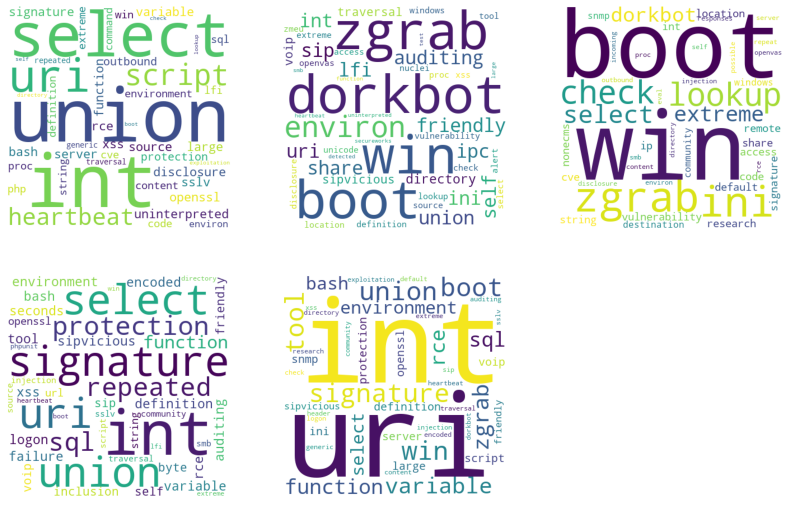

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
number_of_topics = top2vec.get_num_topics()
df = pd.DataFrame(topic_words).T
df2 = df.iloc[:, ::2] # skip every other column of topic weights
fig = plt.figure(figsize=(14,14))
for i in range(5):
    ax = fig.add_subplot(3,3,i+1)
    comment_words = '' 
    stopwords = set(STOPWORDS)
    for val in df2.iloc[:, i]:      
        val = str(val) 
        # split the value 
        tokens = val.split()     
        comment_words += " ".join(tokens)+" " 
    wordcloud = WordCloud(width = 400, height = 400, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
    
    ax.imshow(wordcloud)
    ax.axis('off')

# **View topics**

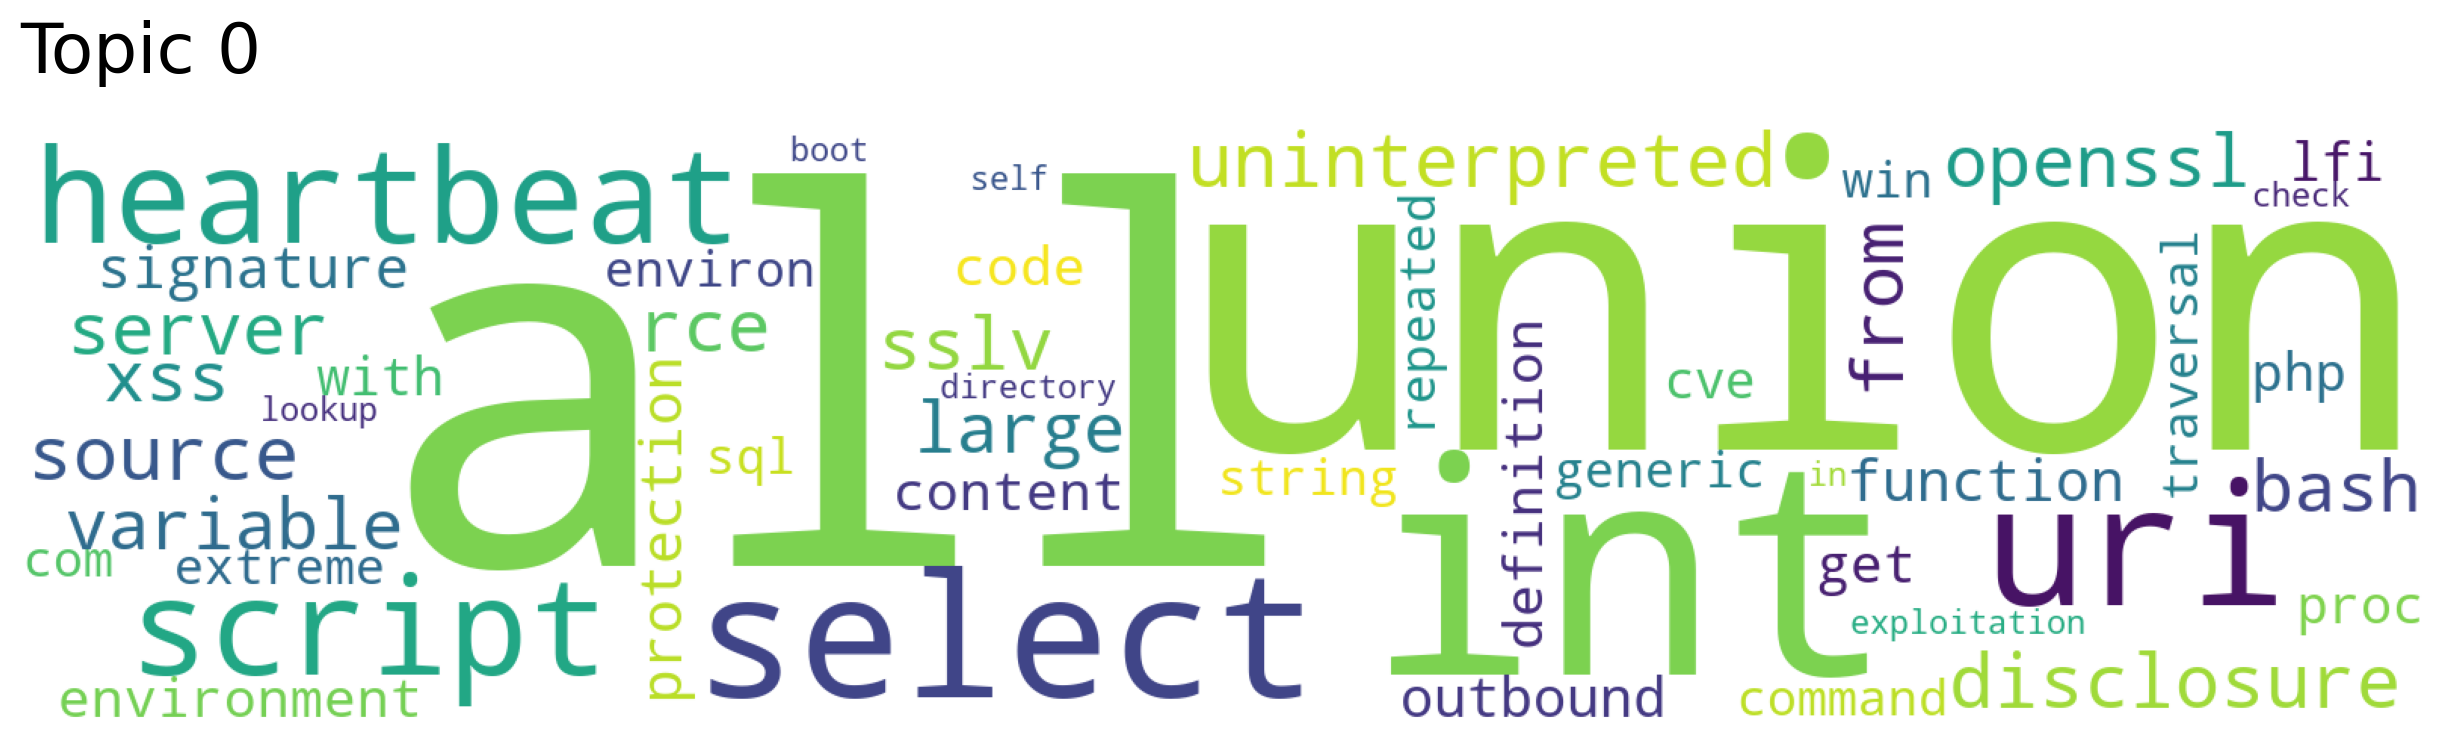

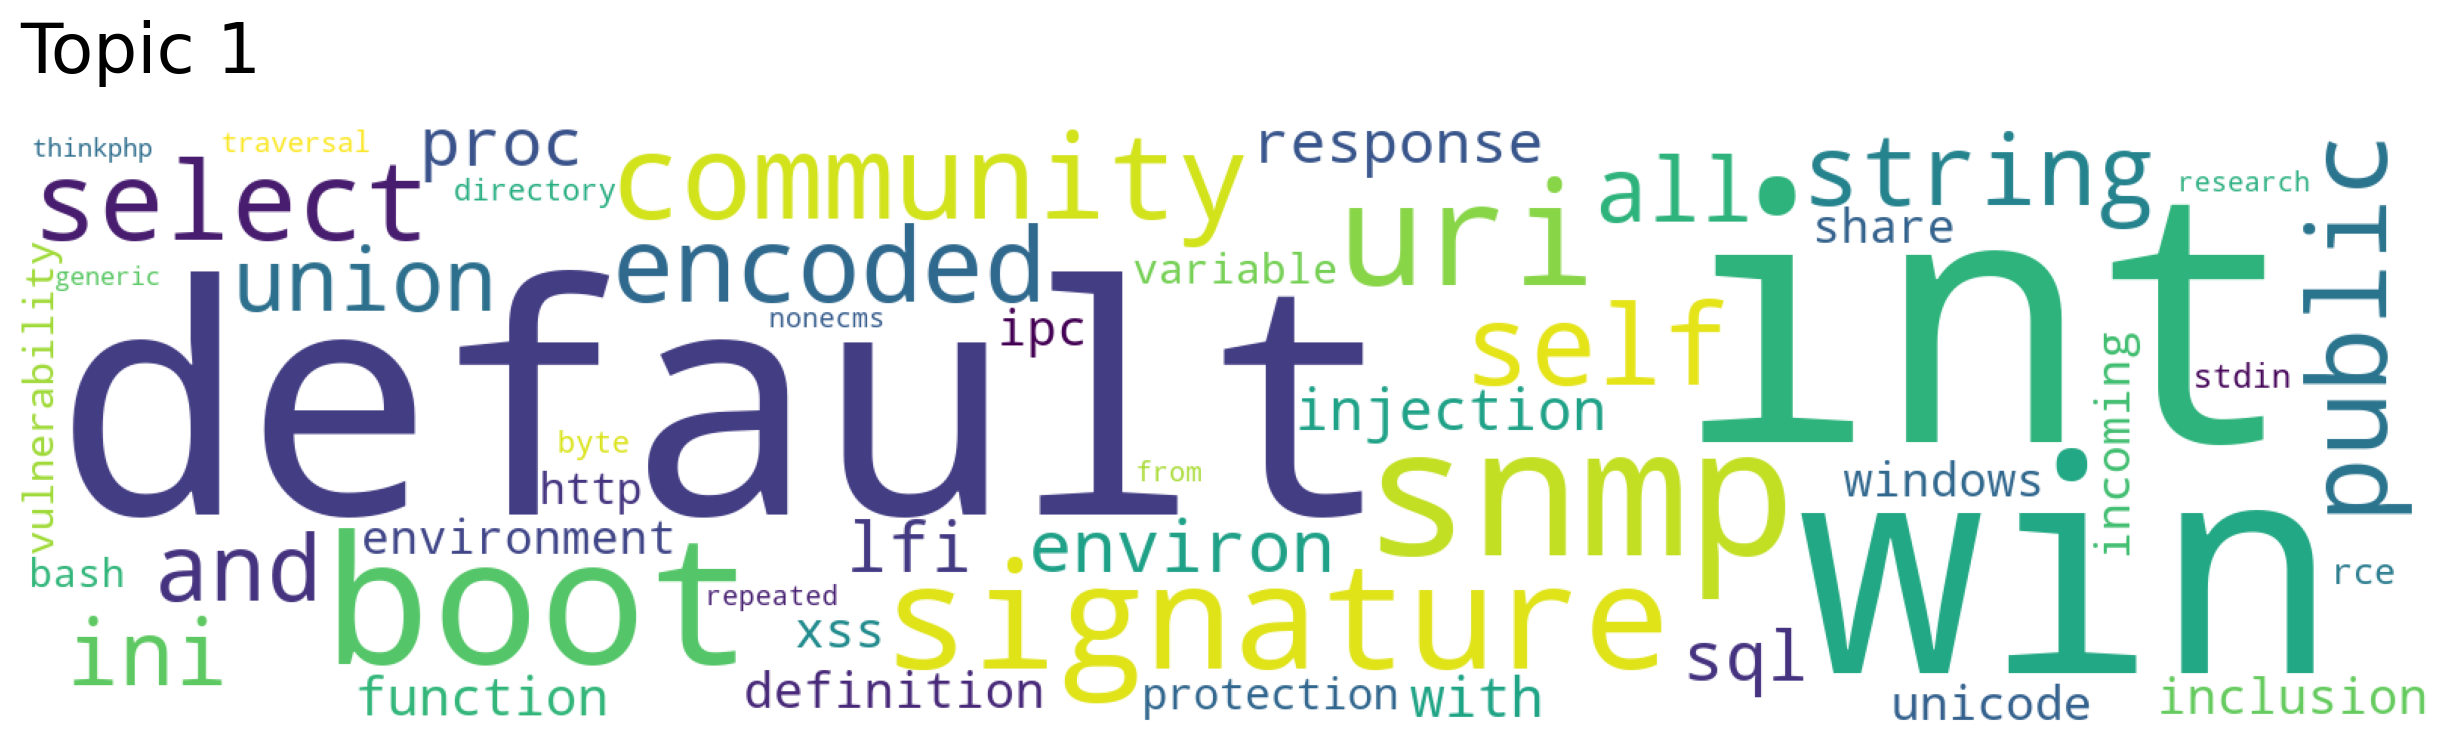

In [ ]:
for topic in topic_nums[0:2]:
    top2vec.generate_topic_wordcloud(topic, background_color="white")

In [ ]:
topic_words,word_scores, topic_scores, topic_nums = top2vec.search_topics(keywords=["microsoft"], num_topics=5)c_words, wor

In [ ]:
topic_nums

[46, 47, 43, 29, 45]

In [ ]:
topic_scores

[0.4426, 0.2871, 0.248, 0.2464, 0.2395]

In [ ]:
documents, document_scores, document_ids = top2vec.search_documents_by_topic(topic_num=48, num_docs=5)

In [ ]:
documents

['  Possible GPON Router Authentication Bypass Attempt Inbound (CVE--)',
 '  SNMP response with default public community string Outbound',
 '  SNMP response with default public community string Outbound',
 '  SNMP response with default public community string Outbound',
 '  Possible NMAP Fingerprint attempt']